# CLIPSeg con máscara invertida y crop basado en detección de rostro (debajo de la cara)
Este notebook usa MTCNN para detectar la cara en la imagen y recorta desde un poco más abajo del mentón hacia arriba. Luego aplica CLIPSeg para generar una máscara invertida (segmentado = blanco, fondo = negro), ideal para inpainting.

In [1]:
pip install transformers torchvision torch matplotlib facenet-pytorch

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from torchvision.transforms.functional import to_pil_image

/Users/florenciatoledo/Desktop/Entorno-Florencia/ml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


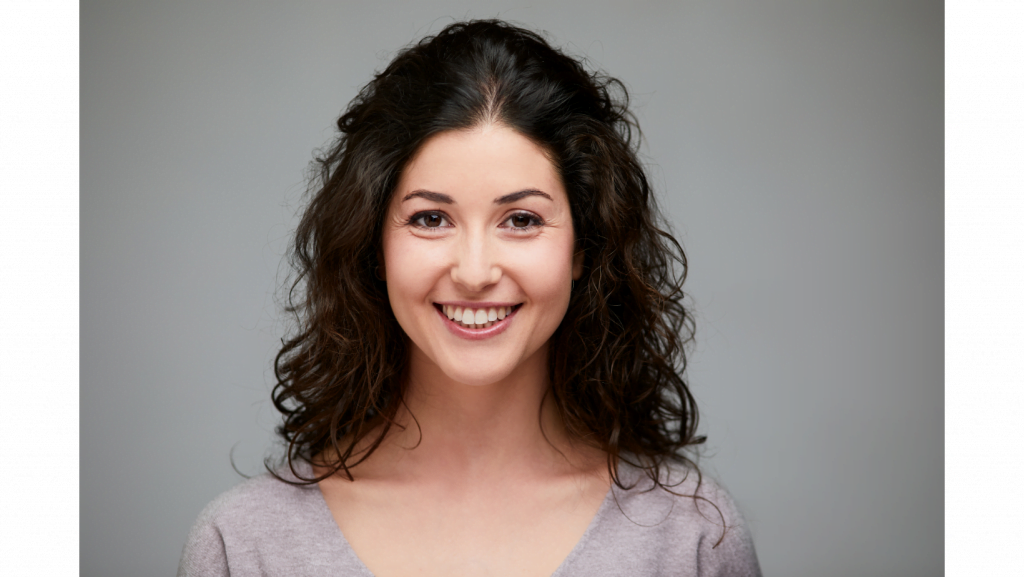

In [11]:
# Cargar imagen y detectar rostro
image_path = "../data/3_image_womenlong_hair.png"  # reemplazá por tu ruta real
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)
mtcnn = MTCNN(keep_all=False, device='cpu')

box, _ = mtcnn.detect(image)

if box is not None and box[0] is not None:
    x1, y1, x2, y2 = map(int, box[0])
    altura_rostro = y2 - y1
    bajo_menton = min(y2 + int(altura_rostro * 1.2), image.height)  # recorte proporcional
    cropped_image = image.crop((0, 0, image.width, bajo_menton))
else:
    raise ValueError("No se detectó rostro en la imagen.")
cropped_image

In [12]:
# Procesamiento con CLIPSeg sobre imagen recortada
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
prompt = "hair"  # o 'head', 'face', etc.

inputs = processor(text=prompt, images=cropped_image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

pred_mask = torch.sigmoid(outputs.logits)[0].squeeze().cpu().numpy()
binary_mask = (pred_mask > 0.5).astype("float32")

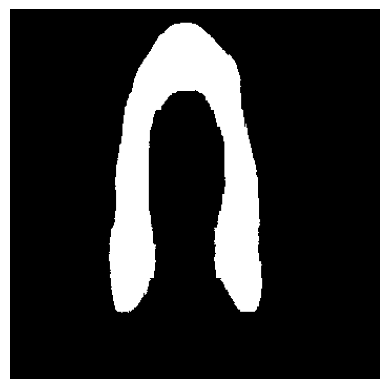

In [14]:
# Mostrar máscara invertida (segmento en blanco)
plt.imshow(binary_mask, cmap="gray")
plt.axis("off")
plt.show()

# Guardar imagen
mask_img = Image.fromarray((binary_mask * 255).astype("uint8"))
mask_img.save("../data/4_mask_inverted.png")